<a href="https://colab.research.google.com/github/alejogiley/ChemGraphs/blob/prototype/notebooks/playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

url='https://raw.githubusercontent.com/alejogiley/ChemGraphs/prototype/datasets/estrogen_receptor_alpha.sdf'
curl $url --output estrogen_receptor_alpha.sdf 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.6M  100 34.6M    0     0  26.2M      0  0:00:01  0:00:01 --:--:-- 26.2M


In [4]:
%%bash
url='https://raw.githubusercontent.com/alejogiley/ChemGraphs/prototype/datasets/EstrogenGraphs.gz'
curl $url --output EstrogenGraphs.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5109k  100 5109k    0     0  20.2M      0 --:--:-- --:--:-- --:--:-- 20.2M


In [5]:
%%bash

x86='/usr/lib/x86_64-linux-gnu'
url='https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'

# download & extract
curl -L $url | tar xj lib

# move to python packages directory
mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
mv lib/*.so.* $x86/

# rdkit need libboost
ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3701    0  3701    0     0  10758      0 --:--:-- --:--:-- --:--:-- 10727
100 20.2M  100 20.2M    0     0  4712k      0  0:00:04  0:00:04 --:--:-- 5381k
mv: cannot move 'lib/python3.6/site-packages/rdkit' to '/usr/local/lib/python3.6/dist-packages/rdkit': Directory not empty
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libboost_python3.so.1.65.1': File exists


In [6]:
import sys

sys.path.append('/usr/local/lib/python3.6/site-packages')

In [48]:
%%capture

!pip install spektral
!pip install tensorflow-addons

In [53]:
import os
import joblib

import numpy as np
import tensorflow as tf
import scipy.sparse as sp
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
sns.set()

from rdkit import Chem
from rdkit.Chem import AllChem
#from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import Draw

from keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import (
    TimeDistributed,
    Dense, Input, Lambda,
    Embedding, Dropout,
    BatchNormalization)

from spektral.data import BatchLoader, Dataset, Graph
from spektral.transforms import LayerPreprocess
from spektral.layers import (
    ECCConv, GCSConv, GlobalAttnSumPool,
    MinCutPool, GlobalSumPool)

#IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
tf.config.run_functions_eagerly(True)

In [9]:
def onehot_encoding(x, keys):
    maps = dict([(k, v) for k, v in zip(keys, range(len(keys)))])
    return to_categorical(maps[x], num_classes=len(keys))

def symmetrize(matrix):
    return matrix \
        + np.transpose(matrix, (1, 0, 2)) \
        - np.diag(matrix.diagonal())

def get_nodes(mol):
    AllChem.ComputeGasteigerCharges(mol)
    
    nodes = np.array([( 
        Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()),
        atom.GetDoubleProp("_GasteigerCharge"),
        atom.GetDegree())
        for atom in mol.GetAtoms()
    ])

    return nodes

def get_edges(mol):
    """
    Same with nodes, the bond types here are
    {'AROMATIC', 'DOUBLE', 'SINGLE', 'TRIPLE'}
    but the number of classes in rdkit is larger
    *temporary solution

    """
    keys = ['AROMATIC', 'DOUBLE', 'SINGLE', 'TRIPLE']

    natms = mol.GetNumAtoms()
    edges = np.zeros((natms, natms, len(keys)))
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges[i, j] = onehot_encoding(
            str(bond.GetBondType()), keys)
    
    return symmetrize(edges)

def str_is_float(s):
    
    try:
        float(s)
        return True
    
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    
    except (TypeError, ValueError):
        pass
 
    return False

def get_labels(mol, key='IC50 (nM)'):
    """Generate label data for each molecule
    
    "rigth" and "left" indicates whether value is right-censored ">"
    or lef-censored "<" which are reported for concentrations beyond 
    detection limits.
    
    "conc" containts the reported concentration values
    angle brackets are removed and boundary values are saved.
    when conc value is 0, it means metric was not reported.
    
    """
    # read potency metric
    sample = mol.GetPropsAsDict()[key]
    # remove leading and trailing whitespaces
    sample = sample.strip()
        
    # below exp. range
    if "<" in sample: 
        
        left = 1
        right = 0
        
        conc = sample.replace('<', '')
        conc = float(conc)

    # outside exp. range
    elif ">" in sample:
        
        left = 0
        right = 1
        
        conc = sample.replace('>', '')
        conc = float(conc)

    # inside exp. range
    elif str_is_float(sample):
        
        left = 0
        right = 0 
        
        conc = sample
        conc = float(conc)

    # no data provided
    else:
        
        left = 0
        right = 0
        conc = 0.0
    
    return np.array([left, right, conc])

In [10]:
%%time

# create instance of sdf reader
suppl = Chem.SDMolSupplier('estrogen_receptor_alpha.sdf', sanitize=True, strictParsing=True)

# read all molecules besides ones with errors into a list
mols = [mol for mol in suppl if mol is not None]

# Get nodes
x = [get_nodes(mol) for mol in mols]
    
# Adjacency matrices
a = [Chem.rdmolops.GetAdjacencyMatrix(mol) for mol in mols]

# Edge features: bond types
e = [get_edges(mol) for mol in mols]

# Labels: (rank, IC50s)
# this metric is less reliable than e.g. Kd as 
# it depends on the of the substrates used in 
# the essay and it is cell type dependent.
y = [get_labels(mol) for mol in mols]

CPU times: user 2min 46s, sys: 14.9 s, total: 3min 1s
Wall time: 3min 1s


In [9]:
class EstrogenDB(Dataset):
    """Dataset from BindingDB
    """
    def __init__(self, 
                 n_samples=1000,
                 dpath=None, 
                 nodes=None, 
                 edges=None,
                 adjcs=None, 
                 feats=None,
                 **kwargs):
        self.n_samples = n_samples
        self.nodes = nodes
        self.edges = edges
        self.adjcs = adjcs
        self.feats = feats
        # dataset to load
        self.dpath = dpath
        
        super().__init__(**kwargs)
	
    @Dataset.path.getter
    def path(self):
	    path = os.path.join(self.dpath, f'EstrogenDB.npz')
	    return '' if not os.path.exists(path) else path
	        
    def read(self):
        # create Graph objects
        data = np.load(
            os.path.join(
                self.dpath, 
                f'EstrogenDB.npz'), 
            allow_pickle=True)
        
        if self.n_samples > len(data['y']):
            self.n_samples = len(data['y'])          
        
        output = [
            self.make_graph(
                node=data['x'][i],
                adjc=data['a'][i], 
                edge=data['e'][i],
                feat=data['y'][i])
            for i in range(self.n_samples)
            if data['y'][i][-1] > 0.0
        ]
        
        # update samples
        self.n_samples = len(output)
        
        return output
    
    def download(self):
        # save graph arrays into directory
        filename = os.path.join(self.dpath, f'EstrogenDB')
        
        np.savez_compressed(
            filename, 
            x=self.nodes, 
            a=self.adjcs, 
            e=self.edges, 
            y=self.feats)
    
    @staticmethod
    def make_graph(node, adjc, edge, feat):
        # The node features
        x = node.astype(float)
        
        # The adjacency matrix
        # convert to scipy.sparse matrix
        a = adjc.astype(np.int8)
        a = sp.csr_matrix(a)
        # check shape (n_nodes, n_nodes)
        assert a.shape[0] == len(node)
        assert a.shape[1] == len(node)
        
        # The labels
        y = feat.astype(float)
        # transform IC50 values
        # into pIC50
        y[-1] = np.log10(y[-1])
        
        # The edge features 
        e = edge.astype(np.int8)
        # check shape (n_nodes, n_nodes, ..)
        assert e.shape[0] == len(node)
        assert e.shape[1] == len(node)
        
        return Graph(x=x, a=a, e=e, y=y)

In [11]:
# path = "/content/"

# dataset = EstrogenDB(
#     n_samples=5000,
#     nodes=x, edges=e, 
#     adjcs=a, feats=y, 
#     dpath=path)

In [ ]:
# path ='/content/EstrogenGraphs.gz'

# joblib.dump(dataset, path, compress=('gzip', 6))
dataset = joblib.load('EstrogenGraphs.gz')

In [12]:
# Transform the adjacency matrix 
# according to ECCConv
dataset.apply(LayerPreprocess(ECCConv))

# randomize indexes
indxs = np.random.permutation(len(dataset))

# split 90%/10%
split = int(0.9 * len(dataset))

# Train/test indexes
trnxs, tesxs = np.split(indxs, [split])

# Dataset partition
train, tests = dataset[trnxs], dataset[tesxs]

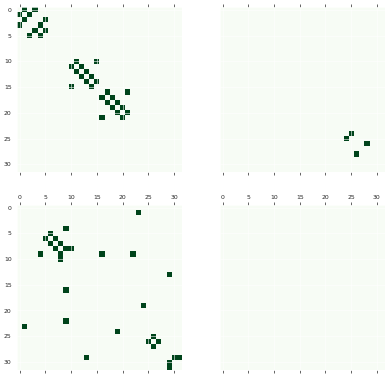

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=40, sharey=True, sharex=True)

k = 0
axes[0, 0].matshow(tests[k]['e'][:,:,0], vmin=0, vmax=1, cmap ='Greens')
axes[0, 1].matshow(tests[k]['e'][:,:,1], vmin=0, vmax=1, cmap ='Greens')
axes[1, 0].matshow(tests[k]['e'][:,:,2], vmin=0, vmax=1, cmap ='Greens')
axes[1, 1].matshow(tests[k]['e'][:,:,3], vmin=0, vmax=1, cmap ='Greens')
plt.show()

In [33]:
def tobit_loss(y_true, y_pred, sigma, eps=1e-7):

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # indicators of left-, right-censoring
    y_lefts = y_true[:, 0]
    y_right = y_true[:, 1]
    y_value = y_true[:, 2]
    
    # normal distribution
    normal = tfp.distributions.Normal(loc=0., scale=1.)
    
    # probability function of normal distribution at point y_value
    prob = normal.prob((y_value - y_pred) / sigma) / sigma
    # probability of point random variable being > than y_value
    right_prob = 1 - normal.cdf((y_value - y_pred) / sigma)
    # probability of random variable being < than y_value
    lefts_prob = normal.cdf((y_value - y_pred) / sigma)
    
    # clip tensor values
    prob = tf.clip_by_value(
        prob, 
        clip_value_min=eps, 
        clip_value_max=1/eps)
    
    right_prob = tf.clip_by_value(
        right_prob, 
        clip_value_min=eps, 
        clip_value_max=1/eps)
        
    left_prob = tf.clip_by_value(
        lefts_prob, 
        clip_value_min=eps, 
        clip_value_max=1/eps)
    
    # logarithm of likelihood
    logp = tf.math.log(prob) * (1 - y_right) * (1 - y_lefts) \
           + tf.math.log(right_prob) * y_right * (1 - y_lefts) \
           + tf.math.log(lefts_prob) * y_lefts * (1 - y_right)
    
    return - tf.reduce_sum(logp)

def masked_mse(y_true, y_pred):

    # indicators of left-, right-censoring
    y_lefts = tf.cast(y_true[:, 0], dtype=tf.int32)
    y_right = tf.cast(y_true[:, 1], dtype=tf.int32)

    mask = (1 - y_right) * (1 - y_lefts)
    mask = tf.logical_not(tf.equal(mask, 0))

    true = tf.boolean_mask(y_true[:, 2], mask)
    pred = tf.boolean_mask(y_pred[:, 0], mask)

    loss = tf.reduce_mean(tf.square(true - pred))
    return tf.where(tf.math.is_nan(loss), 0.0, loss)

def masked_rsq(y_true, y_pred):
    """
    R**2 = 1 - SS_res / SS_tot

    SS_res = Sum (true - <true>)**2
    where SS_res is the residual sum of squares, 

    SS_tot = Sum (true - pred)**2
    and SS_tot is the total sum of squares.
    
    """
    # indicators of left-, right-censoring
    y_lefts = tf.cast(y_true[:, 0], dtype=tf.int32)
    y_right = tf.cast(y_true[:, 1], dtype=tf.int32)

    mask = (1 - y_right) * (1 - y_lefts)
    mask = tf.logical_not(tf.equal(mask, 0))

    true = tf.boolean_mask(y_true[:, 2], mask)
    pred = tf.boolean_mask(y_pred[:, 0], mask)
    mean = tf.reduce_mean(true)

    # r2
    ssres = tf.reduce_sum(tf.square(true - pred))
    sstot = tf.reduce_sum(tf.square(true - mean))

    return 1.0 - tf.math.divide_no_nan(ssres, sstot)

    # pearson
    # mean_x = tf.reduce_mean(true)
    # mean_y = tf.reduce_mean(pred)

    # mean_x2 = tf.reduce_mean(true * true)
    # mean_y2 = tf.reduce_mean(pred * pred)
    # mean_xy = tf.reduce_mean(true * pred)

    # num = (mean_xy - mean_x * mean_y) * (mean_xy - mean_x * mean_y)
    # den = (mean_x2 - mean_x * mean_x) * (mean_y2 - mean_y * mean_y)
    # return tf.math.divide_no_nan(num, den)

In [60]:
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units=1):
        
        super(SimpleDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='random_normal',
            trainable=True)
        
        self.b = self.add_weight(
            shape=(self.units, ),
            initializer='random_normal',
            trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class GCNN(tf.keras.Model):

    def __init__(self, nodes_shape, edges_shape, channels, n_layers, **kwargs):
        
        super(GCNN, self).__init__()

        # initialize operations
        self.dropout = Dropout(0.15)
        self.pooling = GlobalAttnSumPool()
        self.batchnm = BatchNormalization()
        
        self.convs = []
        self.batch = []
        # initialize edge-conditioned
        # convolutional layers
        for i in range(n_layers):
            self.batch.append(
                BatchNormalization(renorm=True))
            self.convs.append(
                ECCConv(channels[i], activation='elu'))
            
        # embedding for edges
        self.embedding = TimeDistributed(Dense(16, use_bias=False))

        # initialize dense layers
        self.dense = Dense(8, "elu")
        # last layer linear model: y = ax + b
        self.linear = SimpleDense(1)

        # format layers
        self.format = Lambda(lambda x: tf.cast(x, tf.float32))

        # Parameters of the model
        self.X = Input(shape=(None, nodes_shape))
        self.A = Input(shape=(None, None))
        self.E = Input(shape=(None, None, edges_shape))

        self.inp = [self.X, self.A, self.E]
        self.out = self.call(self.inp)
        super(GCNN, self).__init__(inputs=self.inp, outputs=self.out, **kwargs)

    def build(self):
        
        self._is_graph_network = True
        self._init_graph_network(inputs=self.inp, outputs=self.out)

    def call(self, input, **kwargs):
        
        x, a, e = input
        a = self.format(a)
        e = self.embedding(e)

        for conv, batch in zip(
            self.convs, self.batch):
            x = batch(conv([x, a, e]))

        # Max node features
        x = self.pooling(x)

        # MLP block
        x = self.dense(x)
        x = self.dropout(x)
        x = self.batchnm(x)

        return self.linear(x)

    @tf.function
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [61]:
def train_model(dataset, epochs, learning_rate, channels, n_layers): 
    """Add typecasting! ... """
    
    # Parameters
    F = dataset.n_node_features  # Dimension of node features
    S = dataset.n_edge_features  # Dimension of edge features

    # Create GCN model
    model = GCNN(
        nodes_shape=F, 
        edges_shape=S, 
        channels=channels, 
        n_layers=n_layers 
    )

    # Learning rate scheduler
    lr_schedule = ExponentialDecay(
    learning_rate,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
    
    # Compile GCN
    model.compile(
        optimizer=tfa.optimizers.LazyAdam(learning_rate), 
        metrics=[masked_rsq],
        loss=masked_mse)
    
    # Print network summary
    model.summary()
    
    # Loader returns batches of graphs
    # with zero-padding done batch-wise
    loader = BatchLoader(
        dataset, batch_size=batch_size)
    
    # Trains the model
    history = model.fit(
        loader.load(),
        epochs=epochs,
        steps_per_epoch=loader.steps_per_epoch)
    
    return model, history

In [62]:
epochs = 100  # Number of training epochs
batch_size = 32 # MiniBatch sizes
learning_rate = 1e-2 # Optimizer learning rate

n_layers = 2  # number of ECCConv layers
channels = [64, 16]  # number of Hidden units

In [ ]:
model, history = train_model(train, epochs, learning_rate, channels, n_layers)

Model: "gcnn_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, None, None)] 0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, None)   0           input_29[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


98/98 [==============================] - 33s 338ms/step - loss: 4.7300 - masked_rsq: -1.3738
Epoch 2/100
98/98 [==============================] - 32s 321ms/step - loss: 1.9161 - masked_rsq: 0.0381
Epoch 3/100
98/98 [==============================] - 32s 325ms/step - loss: 1.4735 - masked_rsq: 0.2285
Epoch 4/100
98/98 [==============================] - 34s 344ms/step - loss: 1.4382 - masked_rsq: 0.2581
Epoch 5/100
98/98 [==============================] - 33s 341ms/step - loss: 1.4801 - masked_rsq: 0.2367
Epoch 6/100
58/98 [================>.............] - ETA: 13s - loss: 1.7804 - masked_rsq: 0.0346

In [ ]:
print("Testing model")

loader = BatchLoader(tests, batch_size=batch_size, shuffle=False)
loss, acc = model.evaluate(loader.load(), steps=loader.steps_per_epoch)
print("Done. Test loss: {} pearson {}".format(loss, acc))

In [ ]:
print("Performance")

pIC50_pred = model.predict(loader.load(), steps=loader.steps_per_epoch)
pIC50_true = np.array([tests[i]['y'][2] for i in range(tests.n_graphs)])

lefts = np.array([tests[i]['y'][0] for i in range(tests.n_graphs)])
right = np.array([tests[i]['y'][1] for i in range(tests.n_graphs)])
masks = (1 - right) * (1 - lefts)

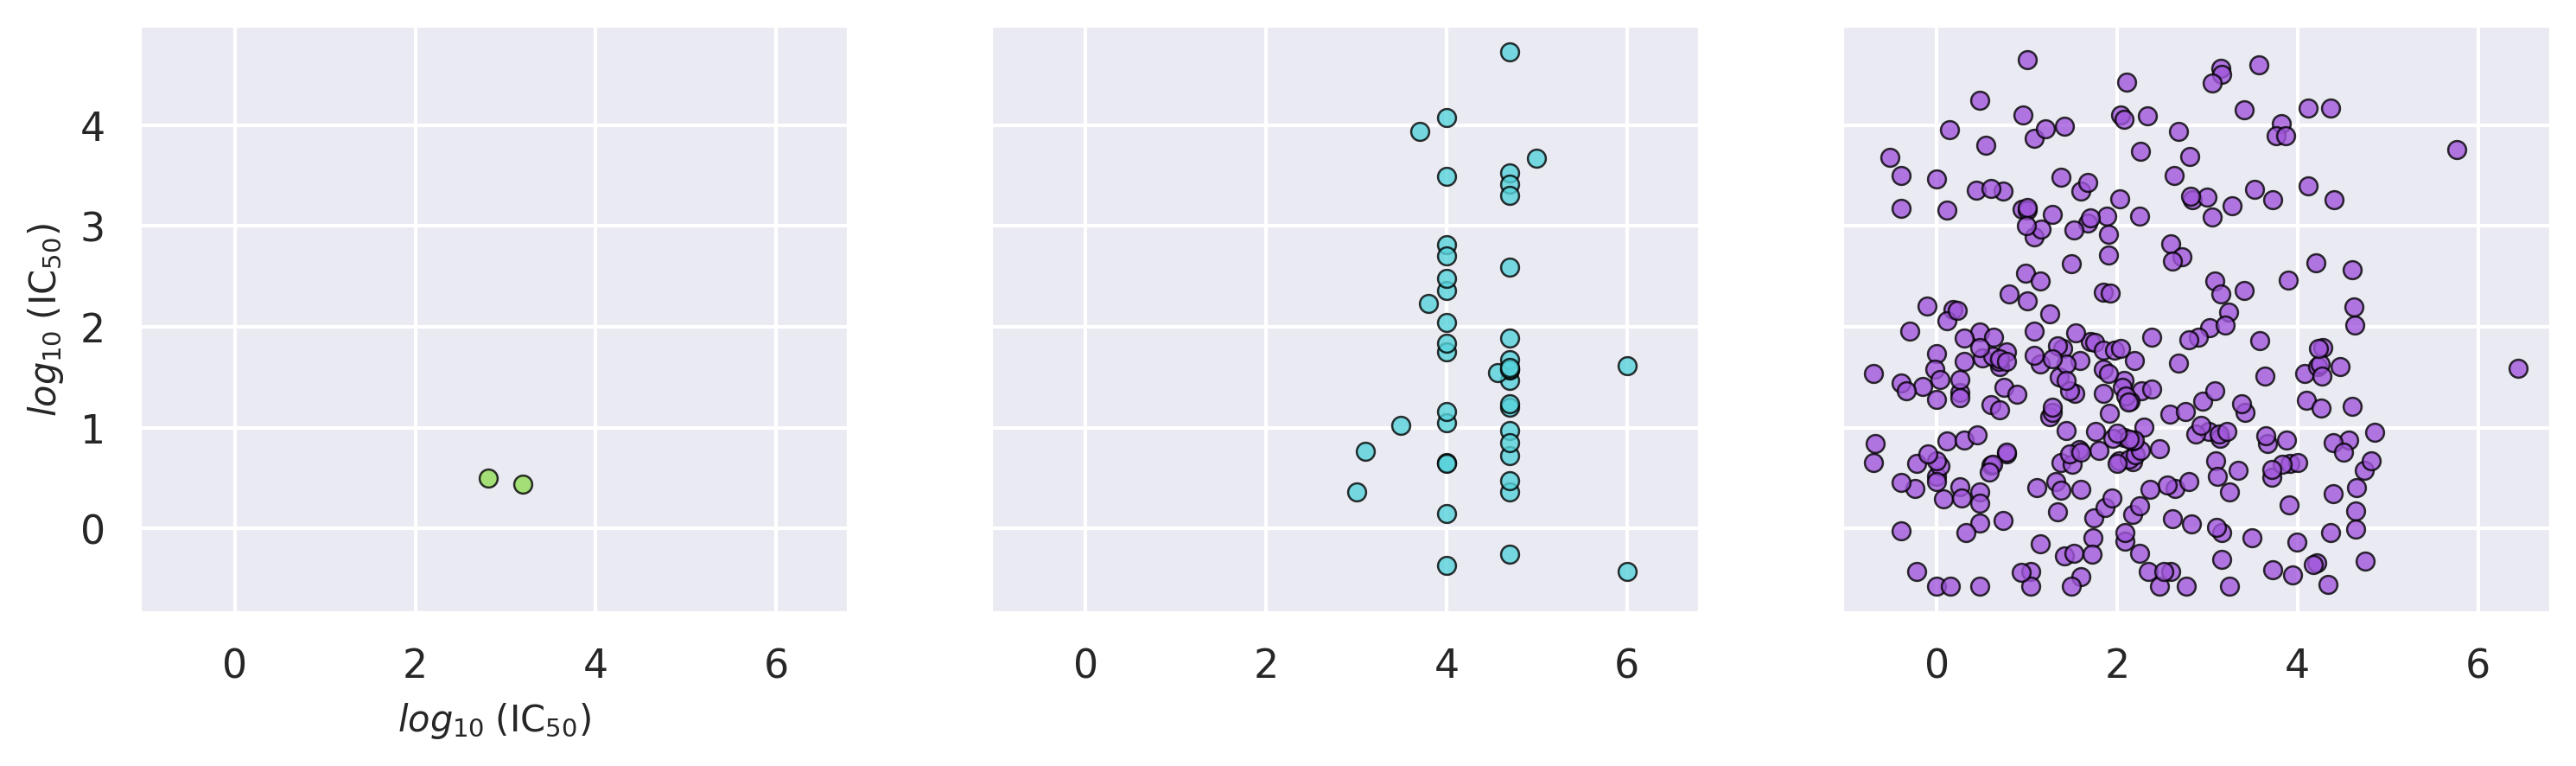

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=300, sharey=True, sharex=True)
cls = sns.color_palette('hls', 4)

axes[0].set_ylabel(r'$log_{10}\;($IC$_{50}$)', fontsize=10)
axes[0].set_xlabel(r'$log_{10}\;($IC$_{50}$)', fontsize=10)

axes[0].plot(pIC50_true[(lefts > 0)], pIC50_pred[(lefts > 0)], 'o', color=cls[1], ms=5, markeredgecolor='black', markeredgewidth=0.6, alpha=0.8)
axes[1].plot(pIC50_true[(right > 0)], pIC50_pred[(right > 0)], 'o', color=cls[2], ms=5, markeredgecolor='black', markeredgewidth=0.6, alpha=0.8)
axes[2].plot(pIC50_true[(masks > 0)], pIC50_pred[(masks > 0)], 'o', color=cls[3], ms=5, markeredgecolor='black', markeredgewidth=0.6, alpha=0.8)

plt.show()